In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [2]:
import pennylane as qml
from pennylane import numpy as np
import jax
from jax import numpy as jnp
import optax
from itertools import combinations
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import matplotlib.colors
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

# Load the digits dataset with features (X_digits) and labels (y_digits)
X_digits, y_digits = load_digits(return_X_y=True)

# Create a boolean mask to filter out only the samples where the label is 2 or 6
filter_mask = np.isin(y_digits, [2, 6])

# Apply the filter mask to the features and labels to keep only the selected digits
X_digits = X_digits[filter_mask]
y_digits = y_digits[filter_mask]

# Split the filtered dataset into training and testing sets with 10% of data reserved for testing
X_train, X_test, y_train, y_test = train_test_split(
    X_digits, y_digits, test_size=0.1, random_state=42
)

# Normalize the pixel values in the training and testing data
# Convert each image from a 1D array to an 8x8 2D array, normalize pixel values, and scale them
X_train = np.array([thing.reshape([8, 8]) / 16 * 2 * np.pi for thing in X_train])
X_test = np.array([thing.reshape([8, 8]) / 16 * 2 * np.pi for thing in X_test])

# Adjust the labels to be centered around 0 and scaled to be in the range -1 to 1
# The original labels (2 and 6) are mapped to -1 and 1 respectively
y_train = (y_train - 4) / 2
y_test = (y_test - 4) / 2

/home/nicola/miniconda3/envs/vvqc/lib/python3.12/site-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.6.2 is installed, but it is not compatible with the installed jaxlib version 0.5.3, so it will not be used.
  warnings.warn(


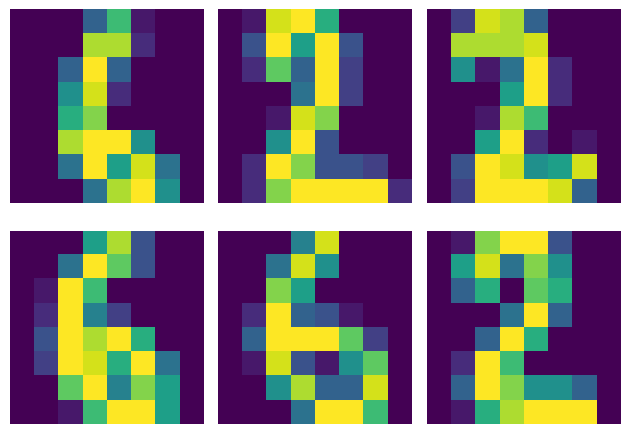

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=3, layout="constrained")
for i in range(2):
    for j in range(3):
      axes[i][j].matshow(X_train[2*(2*j+i)])
      axes[i][j].axis('off')
fig.subplots_adjust(hspace=0.0)
fig.tight_layout()
plt.show()

In [4]:
def feature_map(features):
    # Apply Hadamard gates to all qubits to create an equal superposition state
    for i in range(len(features[0])):
        qml.Hadamard(i)

    # Apply angle embeddings based on the feature values
    for i in range(len(features)):
        # For odd-indexed features, use Z-rotation in the angle embedding
        if i % 2:
            qml.AngleEmbedding(features=features[i], wires=range(8), rotation="Z")
        # For even-indexed features, use X-rotation in the angle embedding
        else:
            qml.AngleEmbedding(features=features[i], wires=range(8), rotation="X")

# Define the ansatz (quantum circuit ansatz) for parameterized quantum operations
def ansatz(params):
    # Apply RY rotations with the first set of parameters
    for i in range(8):
        qml.RY(params[i], wires=i)

    # Apply CNOT gates with adjacent qubits (cyclically connected) to create entanglement
    for i in range(8):
        qml.CNOT(wires=[(i - 1) % 8, (i) % 8])

    # Apply RY rotations with the second set of parameters
    for i in range(8):
        qml.RY(params[i + 8], wires=i)

    # Apply CNOT gates with qubits in reverse order (cyclically connected)
    # to create additional entanglement
    for i in range(8):
        qml.CNOT(wires=[(8 - 2 - i) % 8, (8 - i - 1) % 8])

# Variational approach


In [5]:
dev = qml.device("default.qubit", wires=8)


@qml.qnode(dev)
def circuit(params, features):
    feature_map(features)
    ansatz(params)
    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias


def square_loss(labels, predictions):
    return np.mean((labels - qml.math.stack(predictions)) ** 2)


def accuracy(labels, predictions):
    acc = sum([np.sign(l) == np.sign(p) for l, p in zip(labels, predictions)])
    acc = acc / len(labels)
    return acc


def cost(params, X, Y):
    predictions = [variational_classifier(params["weights"], params["bias"], x) for x in X]
    return square_loss(Y, predictions)


def acc(params, X, Y):
    predictions = [variational_classifier(params["weights"], params["bias"], x) for x in X]
    return accuracy(Y, predictions)


np.random.seed(0)
weights = 0.01 * np.random.randn(16)
bias = jnp.array(0.0)
params = {"weights": weights, "bias": bias}
opt = optax.adam(0.05)
batch_size = 7
num_batch = X_train.shape[0] // batch_size
opt_state = opt.init(params)
X_batched = X_train.reshape([-1, batch_size, 8, 8])
y_batched = y_train.reshape([-1, batch_size])


@jax.jit
def update_step_jit(i, args):
    params, opt_state, data, targets, batch_no = args
    _data = data[batch_no % num_batch]
    _targets = targets[batch_no % num_batch]
    _, grads = jax.value_and_grad(cost)(params, _data, _targets)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return (params, opt_state, data, targets, batch_no + 1)


@jax.jit
def optimization_jit(params, data, targets):
    opt_state = opt.init(params)
    args = (params, opt_state, data, targets, 0)
    (params, opt_state, _, _, _) = jax.lax.fori_loop(0, 200, update_step_jit, args)
    return params


params = optimization_jit(params, X_batched, y_batched)
var_train_acc = acc(params, X_train, y_train)
var_test_acc = acc(params, X_test, y_test)

print("Training accuracy: ", var_train_acc)
print("Testing accuracy: ", var_test_acc)

Training accuracy:  0.7360248447204969
Testing accuracy:  0.6944444444444444


In [7]:
print(params)
# save the parameters to a file
np.savez("variational_params.npz", weights=params["weights"], bias=params["bias"])

{'bias': Array(-0.22726513, dtype=float32), 'weights': Array([-1.0181081e-01,  7.3226631e-01,  4.9697268e-01, -3.5690758e-01,
        4.6779245e-01, -6.3548438e-02, -1.4430081e+00, -1.3503240e+00,
       -1.7692385e+00,  5.8935285e-01,  1.3474429e-01, -1.0524874e+00,
        1.0132782e-01, -5.5722642e-01,  5.5856886e-05, -2.3709021e-04],      dtype=float32)}


In [9]:
read_params = np.load("variational_params.npz")
weights = read_params["weights"]
bias = read_params["bias"]
print("Read weights: ", weights)
print("Read bias: ", bias)

Read weights:  [-1.0181081e-01  7.3226631e-01  4.9697268e-01 -3.5690758e-01
  4.6779245e-01 -6.3548438e-02 -1.4430081e+00 -1.3503240e+00
 -1.7692385e+00  5.8935285e-01  1.3474429e-01 -1.0524874e+00
  1.0132782e-01 -5.5722642e-01  5.5856886e-05 -2.3709021e-04]
Read bias:  -0.22726513
